# Analyzing Single Neuron Activity

In this tutorial we will examine single-neuron data collected from human patients.

This tutorial was originally developed by 
[Salman Qasim](https://seqasim.wixsite.com/research),
and has been updated by
[Tom Donoghue](https://tomdonoghue.github.io/). 

### Requirements

As well as standard scientific Python packages, this tutorial requires 
[pynwb](https://github.com/NeurodataWithoutBorders/pynwb).

In [64]:
# Imports - standard scientific Python packages
import numpy as np
import matplotlib.pyplot as plt

# Imports - single-unit related 
from pynwb import NWBHDF5IO

## Overview

The predominant way in which a neuron communicates is through **action potentials**. These are rapid depolarizations across the neuronal cell membrane that culminate in a neuron releasing neurotransmitters that can do all sorts of things, like excite or inhibit action potentials in other neurons. Because action potentials are characterized by a large and fast change in membrane potential they can be recorded by microwires placed near the neuronal membrane, making them the most direct "biomarker" of neural activity. 

When we look at neuronal spiking during a behavioral task, we are often looking for increases in the rate of spiking related to behavioral variables. This is thought to imply a relationship between the stimulus and the neuron's spiking, and is called **rate coding**. 

Here, we are going to cover some of the basics of analyzing single neuron responses. It is worth noting that, single-unit recordings did not fall under the direct purview of the RAM project's data collections; as such, single-unit data loading and analyses don't follow the same standard protocol you've learned so far. Instead, we provide proprietary loading functions for the data (and do not focus too heavily on data processing). 

## First Dataset: Object Presentation

The first dataset we will use is a an openly available dataset from human patients performing a recognition memory, provided by the 
[Rutishauser Lab](https://www.cedars-sinai.edu/research/labs/rutishauser.html). 

In this task, subjects are presented with pictures of objects, that they are later asked to recall. For our purposes, we will focus on the object presentation. 

For convenience, an example subject is included in this repository. The full dataset is available on 
[OSF repository](https://osf.io/cd6qp/), and described in this 
[paper](https://doi.org/10.1038/s41597-020-0415-9). 

### Load NWB File

The data that we are loading are in the [NWB](https://www.nwb.org/) format.

In this tutorial, we won't go into much details on NWB files. For more information on these files, see these
[NWB examples](https://github.com/TomDonoghue/NWBExamples).

In [26]:
# Load datafile
file_name = 'object_data.nwb'
io = NWBHDF5IO('data/' + file_name, 'r')
nwbfile = io.read()

### Check Units

In [27]:
# Check how many units in the current file
n_units = len(nwbfile.units)
print(n_units)

38


In [32]:
# Set index for the unit of interest
s_ind = 0

In [42]:
# Extract the waveform for the unit of interest
waveform = nwbfile.units['waveform_mean_encoding'][s_ind, :]

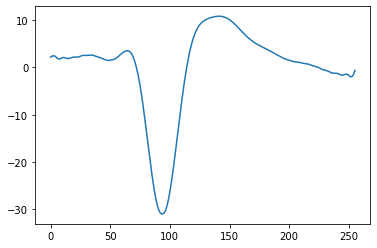

In [40]:
# Plot the waveform of the unit of interest
plt.plot(waveform)

In [ ]:
# Get spikes from a neuron of interest
spikes = nwbfile.units.get_unit_spike_times(s_ind)

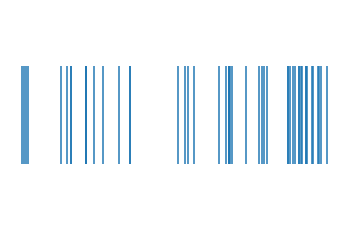

In [62]:
# Plot a raster of a series of spikes
plt.eventplot(spikes[0:50])
plt.axis('off');

### Task Related Activity

## Object Dataset: Possible Extensions

Words, words, words.

## ## Second Dataset: Spatial Navigation


We won't get too much into the intricacies of the event design here vs. in the RAM tasks. Suffice to say they're different; we slice up every 100 ms of time that the person is moving through the track, rather than organizing by "events" like a word appearing onscreen. 

**The critical field in the event structure is the ```timesoffset``` field. The single-neuron recording system might be turned on before the task! And it's certainly turned off after the task stops logging. This field tells you the timepoints, relative to the spike times, that take place during the task**


In this section we will go over some simple single neuron analyses with respect to spatial position and memory. For reference, please see: https://www.nature.com/articles/s41593-019-0523-z

```fr``` is the firing rate of each neuron in a numpy array. Firing rate refers to the number of spikes divided by the amount of time you are looking at.

A key intuition here is that you can only measure "instantaneous" firing rate by **binning** the number of spikes into some window of time. In this case, they have been binned into 100 ms windows. So ```fr.shape[0]``` represents the number of non-overlapping 100 ms bins we have used to characterize the firing rate over time.

```spikeTimes``` is the actual time that each detected spike occurred, with time=0 being the moment the acquisition software was set to "record". Note that this is usually done before the task actually begins, so we (later) will need a way to relate these spike times to the times at which interesting things happen in the task. Spiking data is usually recorded at 30 KHz meaning we have HIGH temporal resolution.

```spikeNames``` tells you the microwire channel on which each neuron was recorded, as well as which cluster this neuron was on the channel. That's important, as an individual microwire can pick up more than one neuron. 


In [5]:
# Load dataset
#subj = 'R1219C'
#session = '0'

In [ ]:
#

### Descriptive Explorations

#### Firing Rate

In [ ]:
def compute_spike_rate(spikes):
    """Estimate spike rate from a vector of spike times, in seconds."""
    
    return len(spikes) / (spikes[-1] - spikes[0])

#def get_spike_time_range(spikes, tmin, tmax):
#    """Extract spike times for a particular time range."""
#    
#    return spikes[np.squeeze(np.logical_and([spikes > tmin], [spikes < tmax]))]

In [ ]:
fr = compute_spike_rate(spikes)
print(fr)

frs = [compute_spike_rate(nwbfile.units.get_unit_spike_times(ind)) \
    for ind in range(n_units)]

frs

In [ ]:
# Plot the mean firing rate for each neuron 
firing_rate_df = pd.DataFrame(fr, columns=spikeNames).melt(var_name='spikeName', value_name='firing_rate')
firing_rate_df['spikeName'] = firing_rate_df['spikeName'].apply(lambda x: x[3:])
f, ax = plt.subplots(1,1, figsize=[14,3])
sns.barplot(x='spikeName', y='firing_rate', data=firing_rate_df, ci=68)

This tells you how active, in general, each neuron was during the recording session. 

#### Inter-Spike Interval

One way to assess spiking activity is to look at the time interval between each spike (aka the **interspike interval**). 

In [ ]:
# Compute ISI for Neuron 1 
# isi = np.diff(np.array(spikes))
# sns.distplot(isi)
# plt.xlabel('ISI (ms)')
# plt.ylabel('density')

#### Coefficient of Variation


The CV does not capture potential variability on longer time scales especially if there's drift in the neuron's mean firing rate over time. A measure of spike time variability taking this long-term variability into account is the Fano factor, the ratio of the mean spike count and the variance the spike count within a time window. We will compute that a little later.

Another useful thing that ISI distribution can tell you is if the neuron you are looking at is a **bursty** neuron. By that, I mean a neuron that tends to fire a lot of action potentials in short bursts, rather than as isolated single spikes. As you can imagine, bursty neurons tend to violate Poisson assumptions and have ISI distributions that look a little more bimodal, with lots of spikes close together, and lots of bursts far apart. But that is a good segue into......

In [ ]:
# Compute coefficient of variation
cv = np.std(isi) / np.mean(isi)
print(cv)

### Data Representations

#### Spike Times

....

#### Spike Trains

...

#### Continuous Firing Rates

Before we go any further, let's look at some spike trains. We didn't do this before because we didn't know when the task started and stopped - now we do, and can define a spike train using the spikes that happened during the task.

## Assignment:

In this assignment, you will analyze human single neuron activity during a virtual-reality spatial memory task. In this task, subjects move down a linear track while encoding and retrieving the locations of objects along the track. You will plot neuronal spiking as a function of time and spatial position, and apply statistical methods for assessing significant changes in both domains. You will also measure the influence of memory cues and memory performance on spiking activity. 

1) Write a general function to plot the raster and histogram at a user defined time window and bin length (for the histogram). Use it to plot the rasters and histograms for CueOn, CueOff, FeedbackOn and FeedbackOff. This function should use baselined spike times and baselined event times/trial as input. Plot the output for one neuron. 

2) Write a similar function using the smoothed spiking activity instead of the PSTH. Keep in mind that the we computed the smoothed spiking activity at 100 Hz. Be sure to allow users to input width of smoothing kernel. You may want to write a separate function to smooth the firing rate, and call that within your function to plot the raster + smoothed firing rate. Plot the output for one neuron, with 3 different smoothing widths for your kernel. 

3) Calculate the mean firing rate and the error on every trial, and plot firing rate as a function of error. Hint: this is going to require that you again split the events into trials using the ```trialNum``` field. 
BONUS: Is there a statistical relationship between firing rate and memory performance? 

4) Do some shuffling to determine if the F-statistic from the spatial ANOVA is significant. Hint: use np.roll() to circularly shift data in a pandas dataframe: 
```df.reindex(index=np.roll(df.index, shift))```. If you see any neurons with a significant interaction in the ANOVA, make a plot of the spatial firing rate split by object. If you see any neurons that do not have a significant interaction but do have a significant main effect of location, make a plot of the spatial firing rate over all trials. 
